In [1]:
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
from talib import abstract
import mplfinance as mpf
#import goo_doc_api as goo
#import yfinance as yf
#import pandas_datareader as web
import matplotlib
#matplotlib.use('ps')
from matplotlib import rc
#rc('text',usetex=True)
# rc('text.latex', preamble='\usepackage{color}')
import matplotlib.pyplot as plt

import datetime
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import io
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import math
import os


In [43]:
cwd = os.getcwd()    
#dir_path = os.path.join(os.path.abspath(os.path.join(cwd, os.pardir)), r"stock_market_data\nasdaq\csv"+'\\')
dir_path = os.path.join(cwd, r"stock_market_data\nasdaq\csv"+'\\')
#stock_list = np.array([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
stock_list = np.array(os.listdir(dir_path))
stock_list = stock_list
tickers_train ,tickers_test = train_test_split(stock_list,test_size=0.2, random_state=1)  
#tickers=["AAPL"] # ,"CS"

# def read_csv(Stock_Name):
# 	df = pd.read_csv(dir_path+str(Stock_Name)+".csv", parse_dates=['Date'], dayfirst=True)
# 	df.set_index('Date', inplace=True)
# 	df=df[:'20240101']
# 	return df


# with Pool(processes=8) as pool: # or whatever your hardware can support

# 	# have your pool map the file names to dataframes
# 	df_list = pool.map(read_csv, tickers_train)

# 	# reduce the list of dataframes to a single dataframe
# 	df = pd.concat(df_list, ignore_index=True)

df_list = []
for i in tickers_train[:500]:#['AAPL.csv']:

	# download stock price data
	Stock_Name= i
	symbol = i
	tickers = symbol
	#df = yf.download(symbol, period='6mo')
	#dir_path = r"C:\D\Ryan\TAMU_class\STAT654\Project\stock_market_data\nasdaq\csv"+'\\'
	#df = pd.read_csv(dir_path+str(Stock_Name)+".csv", parse_dates=['Date'], dayfirst=True)
	#print(Stock_Name)
	df = pd.read_csv(dir_path+str(Stock_Name), parse_dates=['Date'], dayfirst=True)
	
	#df= pd.read_csv(dir_path+str(Stock_Name)+".csv")  # C:\D\Ryan\TAMU_class\STAT654\Project\stock_market_data\nasdaq\csv
	# current_price = web.get_quote_yahoo(tickers)["regularMarketPrice"]
	# print(current_price)
	df.set_index('Date', inplace=True)
	df=df['19930201':'20221212']  # '20100101'
	df_list.append(df)

#df = pd.concat(df_list, ignore_index=True)
	#df.reset_index(inplace=True)
	# Add MACD as subplot


	#macd = MACD(df, 12, 26, 9)
	#stochastic = Stochastic(df, 14, 3)

In [44]:
sp500_path = os.path.join(cwd, r"stock_market_data\SPY_yahoo.csv")
sp500_df = pd.read_csv(sp500_path, parse_dates=['Date'], dayfirst=True)
sp500_df.set_index('Date', inplace=True)
#sp500_df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)
sp500_df.rename(columns={"Adj Close": "Adjusted Close"}, inplace=True)
sp500_df=sp500_df['19930201':'20221212']  # '20100101'


C:\Users\b9081\AppData\Local\Temp\ipykernel_43656\883124070.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  sp500_df = pd.read_csv(sp500_path, parse_dates=['Date'], dayfirst=True)


In [46]:
def sliding_window_iter_array(df, sp500_df, window_size, step_size, future_prediction_days=120):
	"""series is a column of a dataframe"""
	#c = 0
	for start_row in range((df.shape[0] -window_size )//step_size +1 - math.ceil(future_prediction_days/step_size ) ):  ## cannot plus 2  , 10 means upto 10 days return
		data_columns = df.columns
		raw_data=df[data_columns][start_row* step_size   : start_row* step_size      + window_size  ].to_numpy()

		if np.isnan(raw_data).any():
			continue

		price_min = raw_data[:,0].min(axis = 0)
		if price_min < 0.000001:
			continue

		price_max = raw_data[:,0].max(axis = 0)
		if (price_max-price_min) < 0.000001:
			continue

		price_data = (raw_data[:,0]-price_min)/(price_max-price_min)*(price_max/price_min)

		if raw_data[:,1].min() < 0.000001:
			continue
		## mean
		volume_data = raw_data[:,1]/raw_data[:,1].mean()
		## median
		#volume_data = raw_data[data_columns[1]][:,1]/np.median(raw_data[data_columns[1]][:,1])



		raw_data_future=df["Adjusted Close"][start_row* step_size  + window_size    :   start_row* step_size  + window_size+future_prediction_days].iloc[[0, 4, 9, 29, 118]]
		#raw_data_future=df["Adjusted Close"][start_row* step_size  + window_size-1    :   start_row* step_size  + window_size+future_prediction_days].iloc[[0, 1, 5, 10, 30, 120]]
		raw_data_future_date=raw_data_future.index
		try:
			sp500_future = sp500_df.loc[list(raw_data_future_date)].to_numpy()/sp500_df.iloc[sp500_df.index.get_loc(raw_data_future_date[0])-1]
			#sp500_future = sp500_df.loc[list(raw_data_future_date)[1:]].to_numpy()/sp500_df.loc[list(raw_data_future_date)[0]]
			raw_data_future=raw_data_future.to_numpy()/(raw_data[-1,0])
			#raw_data_future=raw_data_future[1:].to_numpy()/(raw_data[-1,0])
			
			## check if there is any nan in the future data, if yes, skip
			if np.isnan(raw_data_future).any():
				continue
			yield price_data, volume_data, raw_data_future/sp500_future

			#yield (raw_data-raw_data.min(axis = 0))/(raw_data.max(axis = 0)-raw_data.min(axis = 0))
			#yield raw_data
			#print(sp500_df.index.get_loc(raw_data_future_date[0])-1)
			#print(raw_data_future_date)
		except:
			continue
		# 	c=c+1
			#print(sp500_df.index.get_loc(raw_data_future_date[0])-1)
			#print(raw_data_future_date)
	# print(c)
# 'C': [0, 1, 2, None, 4]},
# df = pd.DataFrame({'A': list(range(100, 501, 100)),
#                    'B': list(range(-20, -15)),},
				   
#                   index=pd.date_range('2021-01-01', periods=))
		
x_concat = np.array([], dtype=np.int64).reshape(0,120,2)
y_concat = np.array([], dtype=np.int64).reshape(0,5)
for i, df_donttouch in enumerate(df_list):#[df_list[1]]:
	print(tickers_train[i])
	#df_donttouch = df_list[0]
	df = df_donttouch.copy()
	#merge_df = df.join(sp500_df, how='inner', rsuffix='spy_')

	#print(df.shape)
	#print(sp500_df.shape)
	#print(merge_df.shape)
	#df['Volume'][df['Volume']==0] = 0.0000001

	#df['Volume_ratio'] = df['Volume'].div(df['Volume'].shift(1))
	#df['Volume_ratio'] = np.log10(df['Volume_ratio'])

	# df['Volume_MA'] = df['Volume'].rolling(window=3).mean()
	# df.dropna(inplace=True)
	# df.reset_index(drop=True)
	# df['Volume_MA_ratio'] = df['Volume_MA'].div(df['Volume_MA'].shift(1))
	# df.dropna(inplace=True)
	# df.reset_index(drop=True)

	#slice_array=np.array(list(sliding_window_iter_array(df[['Adjusted Close']].to_numpy(), 120,5))) ## remove timestamp
	#slice_array=np.array(list(sliding_window_iter_array(df[['Volume_ratio']].to_numpy(), 120,5))) ## remove timestamp
	#slice_array=np.array(list(sliding_window_iter_array(df[['Adjusted Close', 'Volume']].to_numpy(), 120,5))) ## remove timestamp
	slice_list=list(sliding_window_iter_array(df[['Adjusted Close', 'Volume']], sp500_df['Adjusted Close'], 120,5, 120)) ## remove timestamp
	x_array = np.array([element[:2] for element in slice_list])
	try:
		x_array = np.transpose(x_array, (0, 2, 1))
	except:
		continue
	y_array = np.array([element[2] for element in slice_list])
	x_concat = np.concatenate((x_concat, x_array), axis=0)
	y_concat = np.concatenate((y_concat, y_array), axis=0)
	#y_df = pd.DataFrame({'future_adjusted_close':y_list[0], 'future_date':y_list[0]})
	#y_df.set_index('future_date')

	#slice_array = np.transpose(slice_array, (0, 2, 1))
	#timeless_slice_data=[x.reset_index(drop=True) for x in slice_data]
	#print(x_array.shape)
	#print(y_array.shape)
	#print(x_concat.shape)
	#print(y_concat.shape)

	#np.save('AAPL_slice.npy', slice_array)
	#timeless_slice_data
	## concat list to dataframe  to mulitpe columns and drop index 

	#df_window=pd.concat(timeless_slice_data, axis=1)
	# df_rolling = df_list[0].rolling(120, min_periods=120, step=5)
	# print(type(df_rolling))
	# print([len(window) for window in df_rolling])

# test = x_concat < 0
# print(test.any())
print(x_concat.shape)
print(y_concat.shape)


NSYS.csv
HSIC.csv
AMTX.csv
ITIC.csv
MATW.csv
FTNT.csv
KLXI.csv
PLBC.csv
USLM.csv
SHOO.csv
NBIX.csv
UCTT.csv
LKFN.csv
NATI.csv
SMBC.csv
HDP.csv
ASMB.csv
MCHX.csv
LANC.csv
AMRN.csv
PANL.csv
SHEN.csv
BIND.csv
CTAS.csv
LSTR.csv
CLWT.csv
GLBZ.csv
VIDE.csv
ATLC.csv
HNRDF.csv
SNFCA.csv
AMOT.csv
SPTN.csv
SOHU.csv
DXM.csv
MMU.csv
PRFT.csv
STXS.csv
EVLV.csv
COHU.csv
SAGE.csv
DRRX.csv
HART.csv
WWD.csv
ONB.csv
PRIM.csv
RMGN.csv
OVLY.csv
GLRI.csv
GNCA.csv
PNRG.csv
UTHR.csv
ACAD.csv
STAA.csv
UNB.csv
AMBC.csv
TCFC.csv
PRAY.csv
TWOU.csv
CLDX.csv
HIFS.csv
PEBK.csv
FFWM.csv
NTIC.csv
RGCO.csv
MNTX.csv
BBOX.csv
AFSI.csv
KEYW.csv
ANIP.csv
FBP.csv
ENBP.csv
FUND.csv
ALDX.csv
CFRX.csv
VRTB.csv
EXPE.csv
CLRI.csv
ATEC.csv
PLXS.csv
SPCB.csv
LOGI.csv
GRBK.csv
HTBI.csv
BSPM.csv
ATNM.csv
SNPS.csv
CWCO.csv
NICK.csv
HRZN.csv
CHTR.csv
TSRI.csv
NBN.csv
SMRT.csv
CRTO.csv
FNHC.csv
VBTX.csv
SCOR.csv
BLFS.csv
OPOF.csv
NEPT.csv
WETF.csv
RSYS.csv
MSFG.csv
LINC.csv
SCSC.csv
FSFF.csv
IPDN.csv
CORT.csv
SDAD.csv
OIS.csv
FCBC.csv

In [48]:
# other option tslearn https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html
num_clusters = 30
clusterer = KMeans(n_clusters=num_clusters, random_state=1)
#model=clusterer.fit(slice_data)
# slice_array=slice_array.reshape(slice_array.shape[0], -1)
# model=clusterer.fit(slice_array)
#model=clusterer.fit(slice_array[:,:,1])
model=clusterer.fit(x_concat.reshape(x_concat.shape[0], -1))
# test = x_concat.reshape(x_concat.shape[0], -1) < 0
# print(test.any())

print (model.labels_ , len(model.labels_ ))
# cluster_labels = clusterer.fit_predict(slice_data)

# # Plot the clustered time series
# plt.figure(figsize=(12, 6))
# for i in range(num_clusters):
#     plt.plot(np.mean(slice_data[cluster_labels == i], axis=0), label=f'Cluster {i+1}')
# plt.legend()
# plt.title('Clustered Time Series')
# plt.xlabel('Timestamp')
# plt.ylabel('Value')
# plt.show()

c:\D\Ryan\TAMU_class\STAT654\Project\stat_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[ 6  6  6 ... 19  3  3] 351336


In [53]:
## create color list of number 20 from sns 
import seaborn as sns
colors = sns.color_palette("hls", num_clusters)
print(colors)

labels=np.array(model.labels_).reshape(-1)
#labels=np.array(model.predict(slice_array[:,:,1])).reshape(-1)
labels

print(len(labels))
print(len(x_concat))

[(0.86, 0.3712, 0.33999999999999997), (0.86, 0.47519999999999996, 0.33999999999999997), (0.86, 0.5791999999999999, 0.33999999999999997), (0.86, 0.6832, 0.33999999999999997), (0.86, 0.7872, 0.33999999999999997), (0.8287999999999999, 0.86, 0.33999999999999997), (0.7247999999999999, 0.86, 0.33999999999999997), (0.6207999999999999, 0.86, 0.33999999999999997), (0.5167999999999999, 0.86, 0.33999999999999997), (0.41279999999999994, 0.86, 0.33999999999999997), (0.33999999999999997, 0.86, 0.3712), (0.33999999999999997, 0.86, 0.47519999999999996), (0.33999999999999997, 0.86, 0.5792000000000002), (0.33999999999999997, 0.86, 0.6832), (0.33999999999999997, 0.86, 0.7872000000000001), (0.33999999999999997, 0.8287999999999999, 0.86), (0.33999999999999997, 0.7247999999999999, 0.86), (0.33999999999999997, 0.6207999999999999, 0.86), (0.33999999999999997, 0.5167999999999999, 0.86), (0.33999999999999997, 0.41279999999999994, 0.86), (0.3712, 0.33999999999999997, 0.86), (0.4751999999999996, 0.339999999999999

C:\Users\b9081\AppData\Local\Temp\ipykernel_43656\1856429177.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_price[j].set_yticklabels(xlabels)


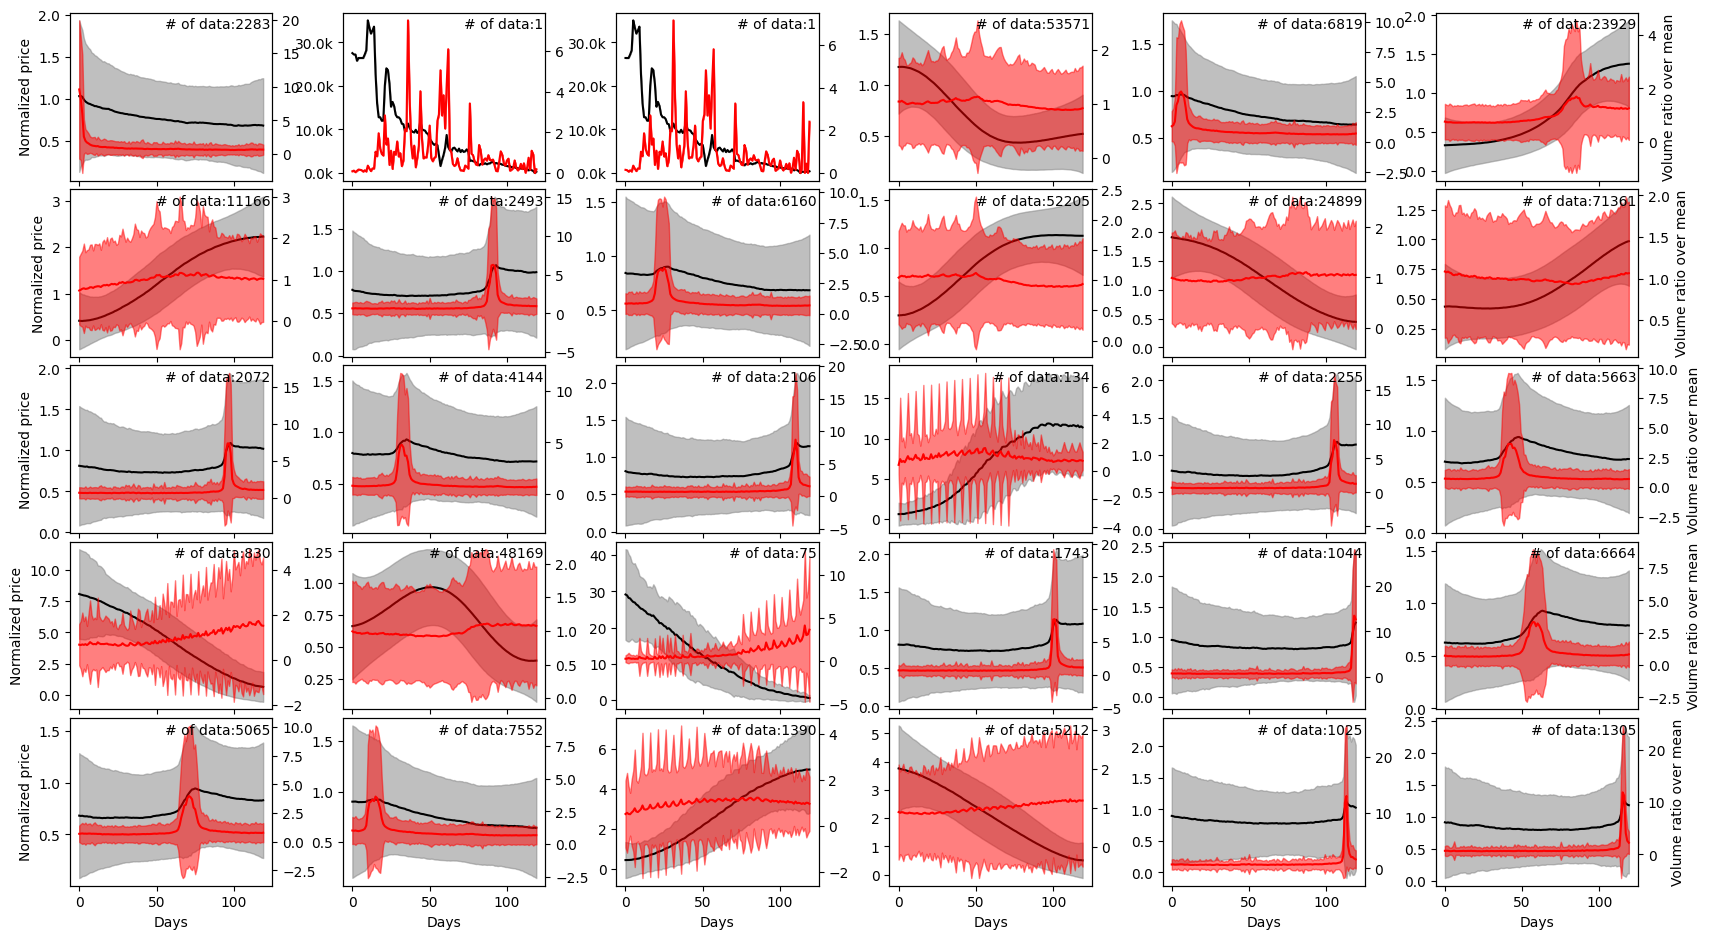

In [57]:
dim_H = int(math.sqrt(num_clusters))
dim_W = math.ceil(num_clusters/int(math.sqrt(num_clusters)))
fig_price, axes_price = plt.subplots(dim_H, dim_W, figsize=(16, 9))
axs_price = axes_price.flatten()
#fig_vol, axes_vol = plt.subplots(dim_H, dim_W, figsize=(12, 12))
#axs_vol = axes_vol.flatten()

for j in range(num_clusters): # range(num_clusters):
	#try:
	#print(j)
	slice_array_label = np.take(x_concat, np.where(labels==j)[0].astype(int), 0)
	column_mean = slice_array_label.mean(axis=0)
	# test = column_mean[:, 0] < 0
	# print(test.any())
	column_std = slice_array_label.std(axis=0)

	ax2 = axs_price[j].twinx()
	ax2.plot(range(0,120),column_mean[:, 1],color='red')
	ax2.fill_between(range(0,120), column_mean[:, 1]-column_std[:, 1], column_mean[:, 1]+column_std[:, 1],color='red', alpha=.5)
	
	
	axs_price[j].plot(range(0,120),column_mean[:, 0],color='black')
	axs_price[j].fill_between(range(0,120), column_mean[:, 0]-column_std[:, 0], column_mean[:, 0]+column_std[:, 0],color='grey', alpha=.5)


	plt.text(.99, .97, "# of data:"+str(len(slice_array_label)), ha='right', va='top', transform=plt.gca().transAxes)
	if j % dim_W == 0:
		axs_price[j].set_ylabel('Normalized price')
		#axs_vol[j].set_ylabel('Volume ratio over mean')
	#ax2.set_ylabel('Volume ratio over mean')
	if j >= (dim_H-1)*dim_W:
		axs_price[j].set_xlabel('Days')
		#axs_vol[j].set_xlabel('Time')
	if j % dim_W == dim_W-1:
		ax2.set_ylabel('Volume ratio over mean')
	#axs_price[j].set_ylabel('Normalized price')
	if axs_price[j].get_ylim()[1] > 1000:

	
		xlabels = ['{:,.1f}'.format(x) + 'k' for x in axs_price[j].get_yticks()/1000]
		axs_price[j].set_yticklabels(xlabels)


	#axs_vol[j].plot(range(0,120),column_mean[:, 1],color='black')
	#axs_vol[j].fill_between(range(0,120), column_mean[:, 1]-column_std[:, 1], column_mean[:, 1]+column_std[:, 1],color='grey')
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.98, wspace=0.35, hspace=0.05)
#plt.legend()
plt.show()

# for j in range(num_clusters): # range(num_clusters):
# 	df_window_label = df_window.iloc[:, np.where(labels==j)[0].astype(int)]
# 	column_mean = df_window_label.mean(axis=1)
# 	column_std = df_window_label.std(axis=1)
# 	axs[j].plot(range(0,120),column_mean,color='black') # label=f'Cluster {i+1}'
# 	axs[j].plot(range(0,120),column_mean-column_std,color='grey') # label=f'Cluster {i+1}'
# 	axs[j].plot(range(0,120),column_mean+column_std,color='grey') # label=f'Cluster {i+1}'
# 	axs[j].fill_between(range(0,120), column_mean-column_std, column_mean+column_std,color='grey')

# plt.show()

	# for i in np.where(labels==j)[0]: 
	#     #for i in group_array:
	# #group_array
	#     #print(i)


	#     #plt.plot(range(0,120),slice_data[i] ,color=colors[j]) # label=f'Cluster {i+1}'
	#     plt.plot(range(0,120),slice_data[i].mean() ,color='black') # label=f'Cluster {i+1}'
	# plt.show()

In [29]:
print(y_concat.shape,x_concat.shape)





(351942, 5) (351942, 120, 2)


C:\Users\b9081\AppData\Local\Temp\ipykernel_43656\442831110.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(day_range, rotation=45, )
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24
25
26
27
28
29


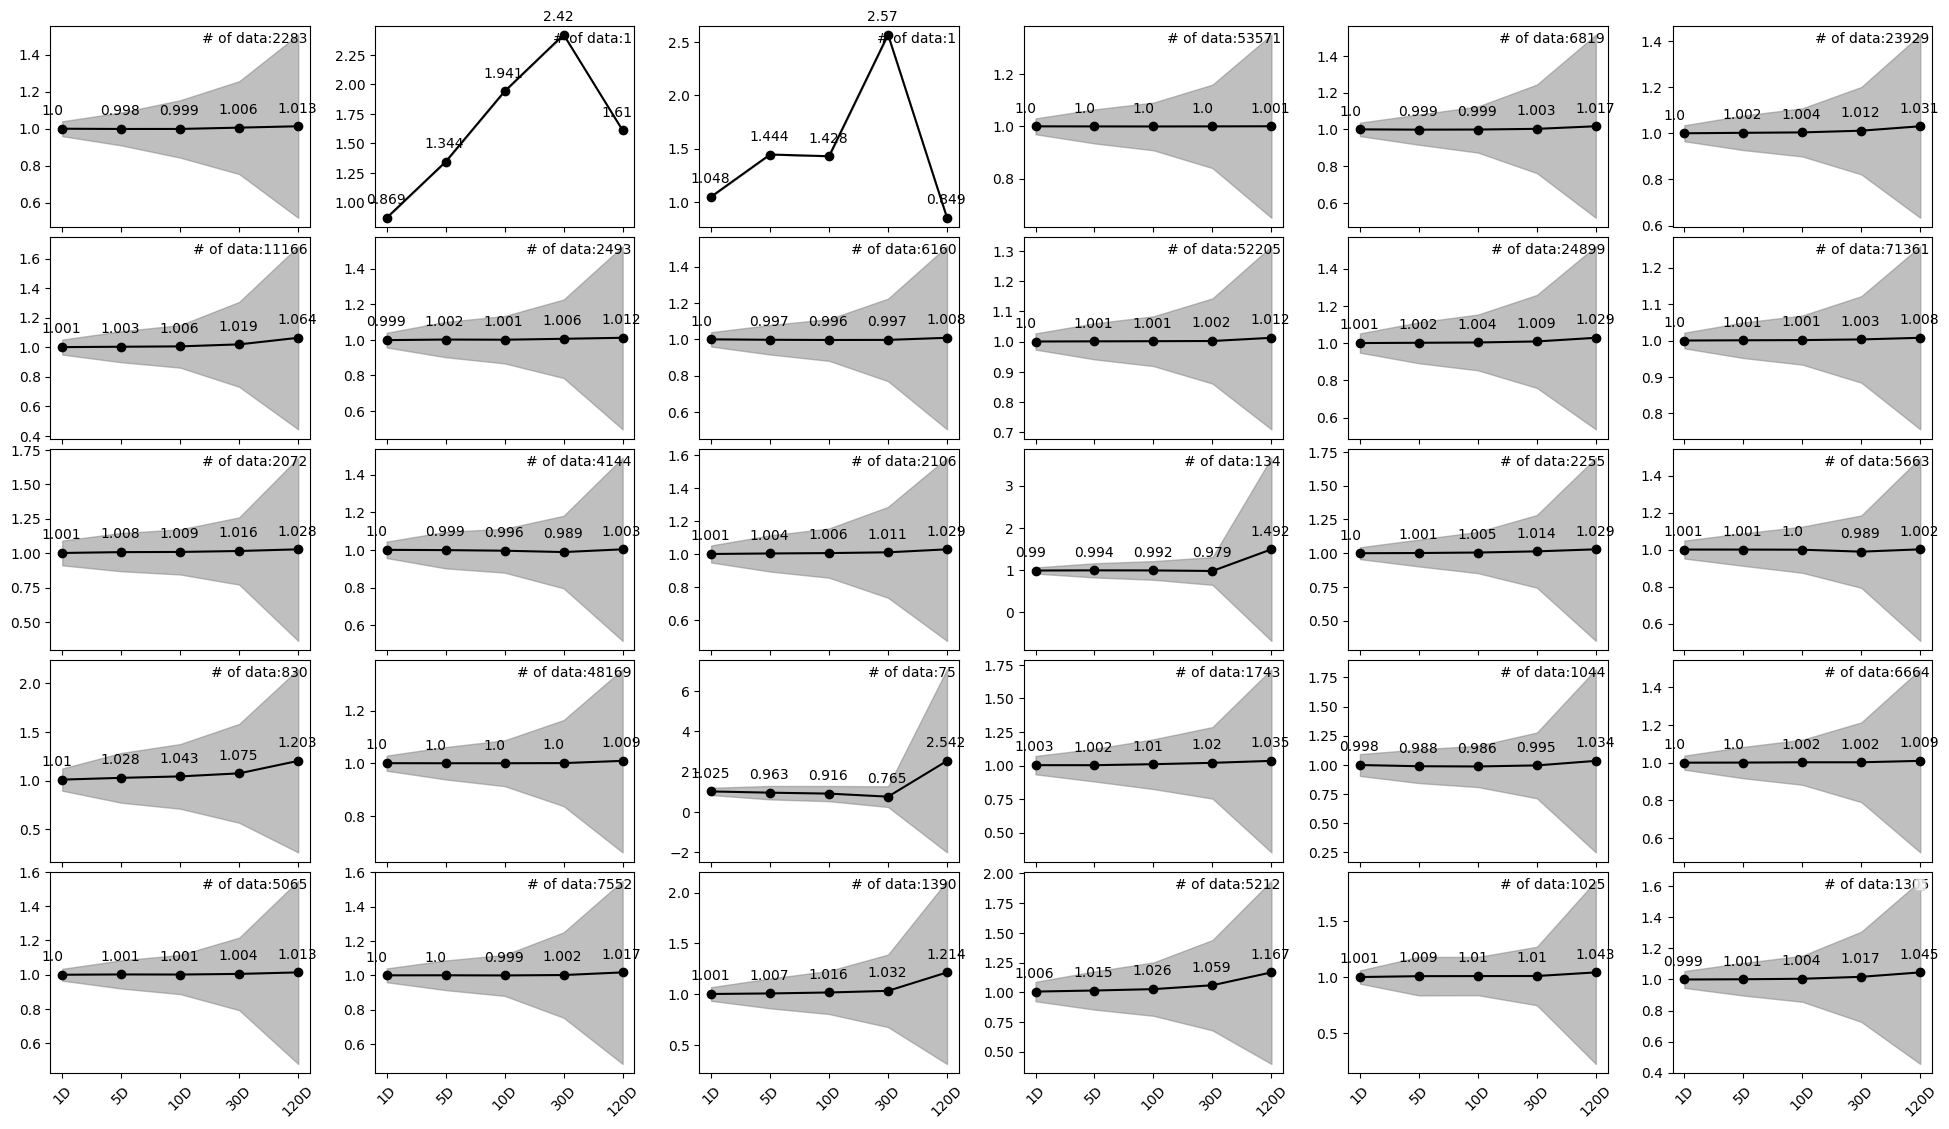

In [84]:
### plot future return

dim_H = int(math.sqrt(num_clusters))
dim_W = math.ceil(num_clusters/int(math.sqrt(num_clusters)))
fig_price_y, axes_price_y = plt.subplots(dim_H, dim_W, figsize=(16*1.2, 9*1.2))
axs_price_new = axes_price_y.flatten()
#fig_vol, axes_vol = plt.subplots(dim_H, dim_W, figsize=(12, 12))
#axs_vol = axes_vol.flatten()


# fig_price, axes_price = plt.subplots(dim_H, dim_W, figsize=(12, 12))
# axs_price = axes_price.flatten()
if 1:
	for j in range(num_clusters): # range(num_clusters):
		#slice_array_label = np.take(x_concat, np.where(labels==j)[0].astype(int), 0)
		#slice_array_label = np.take(x_concat, np.where(labels==j)[0].astype(int), 0)

		y_true= np.take(y_concat, np.where(labels==j)[0].astype(int), 0)
		column_mean = y_true.mean(axis=0)
		column_std = y_true.std(axis=0)
		# if j<5 :
		# 	for k in range( len(y_true)) :
		# 		if np.isnan(y_true[k]).any():
		# 			print(y_true[k])
		ax2 = axs_price_new[j]
		day_range=["1D","5D","10D","30D","120D"]
		ax2.plot(day_range,column_mean,color='black',marker='o')
		ax2.fill_between(day_range, column_mean-column_std, column_mean+column_std,color='grey', alpha=.5)
		
		ax2.text(.99, .97, "# of data:"+str(len(y_true)), ha='right', va='top', transform=ax2.transAxes)
		for k, txt in enumerate( column_mean.round(3).astype(str)):
			ax2.annotate(txt, (day_range[k],column_mean[k] ), xytext=(-15,10), textcoords='offset points')
		ax2.set_xticklabels([])
		if j // dim_W == dim_H-1:
			print(j)
			#ax2.set_ylabel('Normalized price')
			#axs_vol[j].set_ylabel('Volume ratio over mean')
			ax2.set_xticklabels(day_range, rotation=45, )


		
		#print(y_true.mean(axis=0))
		#plt.text(.01, .99, str(y_true.mean(axis=0).round(3)), ha='left', va='top', transform=plt.gca().transAxes)

		# axs_price[j].plot(range(0,120),column_mean,color='black')
		# axs_price[j].fill_between(range(0,120), column_mean[:, 0]-column_std[:, 0], column_mean[:, 0]+column_std[:, 0],color='grey', alpha=.5)





plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.98, wspace=0.25, hspace=0.05)
plt.legend()
plt.show()

# for j in range(num_clusters): # range(num_clusters):
# 	df_window_label = df_window.iloc[:, np.where(labels==j)[0].astype(int)]
# 	column_mean = df_window_label.mean(axis=1)
# 	column_std = df_window_label.std(axis=1)
# 	axs[j].plot(range(0,120),column_mean,color='black') # label=f'Cluster {i+1}'
# 	axs[j].plot(range(0,120),column_mean-column_std,color='grey') # label=f'Cluster {i+1}'
# 	axs[j].plot(range(0,120),column_mean+column_std,color='grey') # label=f'Cluster {i+1}'
# 	axs[j].fill_between(range(0,120), column_mean-column_std, column_mean+column_std,color='grey')

# plt.show()

	# for i in np.where(labels==j)[0]: 
	#     #for i in group_array:
	# #group_array
	#     #print(i)


	#     #plt.plot(range(0,120),slice_data[i] ,color=colors[j]) # label=f'Cluster {i+1}'
	#     plt.plot(range(0,120),slice_data[i].mean() ,color='black') # label=f'Cluster {i+1}'
	# plt.show()
